# Semantic segmentation을 활용해서 합성하기

# 인물사진모드 만들기

In [1]:
import os
import urllib # 웹에서 데이터 다운로드할 때 사용
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation # 시맨틱 세그멘테이션 라이브러리
from matplotlib import pyplot as plt

print('슝=3')

슝=3


### 이미지 및 시맨틱 세그멘테이션을 위한 DeepLab 모델 가져오기

(640, 480, 3)


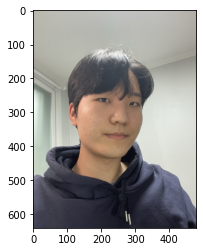

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/selfie.png'
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# 파일 저장 및 경로 지정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델 다운로드
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f9678b38af0>)

In [4]:
# model에 PixelLib에서 다운받은 모델 적용
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# segmentAsPascalvoc() 함수를 통해 PASCAL VOC 데이터로 학습된 모델 아용하기
segvalues, output = model.segmentAsPascalvoc(img_path)

In [5]:
# PASCAL VOC(visual object classes)의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

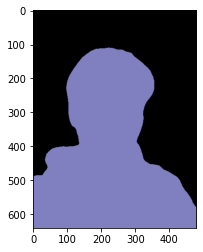

In [6]:
# 세그멘테이션 결과가 각각 다른 색상으로 표현됨
plt.imshow(output)
plt.show()

In [7]:
# class의 id와 masks 확인 가능
print(segvalues)

# class id를 통해 어떤 물체인지 확인
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

{'class_ids': array([ 0, 15]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])}
background
person


In [8]:
# colormap을 통해 output의 색상 확인하기
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

print(colormap[:20])

# 사람을 나타내는 15번째의 색상
print('person is', colormap[15])

[[  0   0   0]
 [128   0   0]
 [  0 128   0]
 [128 128   0]
 [  0   0 128]
 [128   0 128]
 [  0 128 128]
 [128 128 128]
 [ 64   0   0]
 [192   0   0]
 [ 64 128   0]
 [192 128   0]
 [ 64   0 128]
 [192   0 128]
 [ 64 128 128]
 [192 128 128]
 [  0  64   0]
 [128  64   0]
 [  0 192   0]
 [128 192   0]]
person is [192 128 128]


In [9]:
# output의 이미지가 BGR 순서로 배치되어 있으므로 colormap의 RGB 순서처럼 바꿔줘야함
seg_color = (128,128,192)

(640, 480)


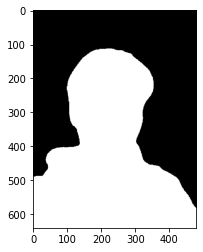

In [10]:
# output의 픽셀 색상이 seg_color와 같으면 1(true) 다르면 0(false)이 된다.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

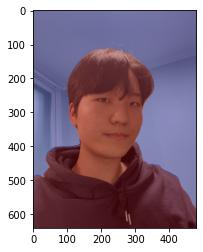

In [11]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾼다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율이다
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

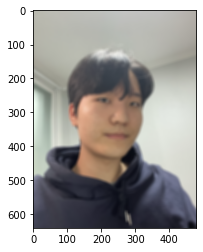

In [12]:
# 배경 blur 적용
img_orig_blur = cv2.blur(img_orig, (10,10)) # 숫자를 키우면 블러 효과 증대
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

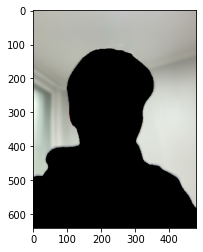

In [13]:
# 세그멘테이션 마스크로 배경 추출하기
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

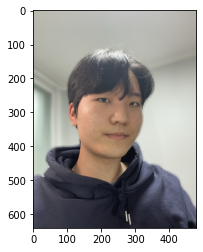

In [14]:
# 흐린 배경과 원본 이미지 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# np.where(조건, 참일때, 거짓일떄) 를 사용해서 합성했다.
result = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
plt.imshow(result)
plt.show()

In [15]:
plt.imsave(f'result_images/selfie.png', result) # 결과 이미지 저장

# 고양이로 인물사진모드 적용하기

(597, 594, 3)


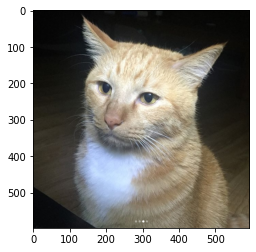

In [16]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

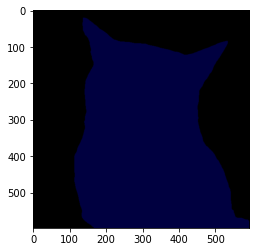

In [17]:
# segmentAsPascalvoc() 함수를 통해 PASCAL VOC 데이터로 학습된 모델 아용하기
segvalues, output = model.segmentAsPascalvoc(img_path)

# 세그멘테이션 결과가 각각 다른 색상으로 표현됨
plt.imshow(output)
plt.show()

In [18]:
# class의 id와 masks 확인 가능
print(segvalues)

# class id를 통해 어떤 물체인지 확인
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    
# 고양이를 나타내는 8번째의 색상
print('cat is', colormap[8])

{'class_ids': array([0, 8]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])}
background
cat
cat is [64  0  0]


(597, 594)


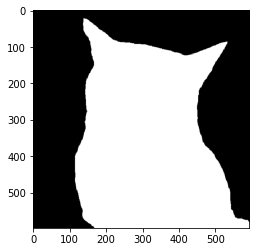

In [19]:
# output의 이미지가 BGR 순서로 배치되어 있으므로 colormap의 RGB 순서처럼 바꿔줘야함
seg_color = (0,0,64)

# output의 픽셀 색상이 seg_color와 같으면 1(true) 다르면 0(false)이 된다.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

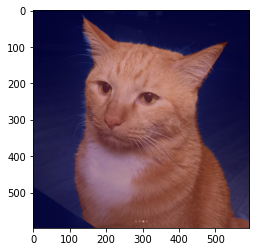

In [20]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾼다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율이다
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

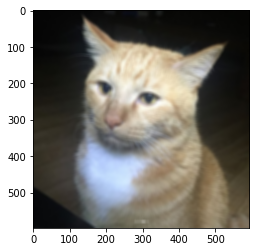

In [21]:
# 배경 blur 적용
img_orig_blur = cv2.blur(img_orig, (10,10)) # 숫자를 키우면 블러 효과 증대
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

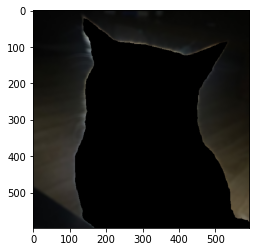

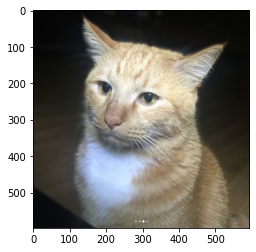

In [22]:
# 세그멘테이션 마스크로 배경 추출하기
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 흐린 배경과 원본 이미지 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# np.where(조건, 참일때, 거짓일떄) 를 사용해서 합성했다.
result = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
plt.imshow(result)
plt.show()

In [23]:
plt.imsave(f'result_images/cat.jpeg', result) # 결과 이미지 저장

# 배경 사진 교체하기

(661, 496, 3)


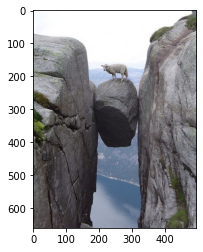

(1333, 2000, 3)


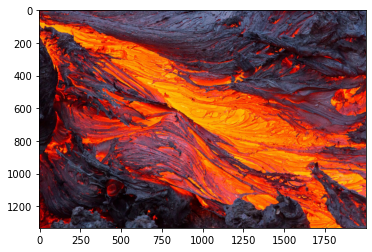

In [24]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sheep_on_the_rock.jpeg'
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

background_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/magma.jpeg'
background_img_orig = cv2.imread(background_img_path) 

print(background_img_orig.shape)
plt.imshow(cv2.cvtColor(background_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

(661, 496, 3)


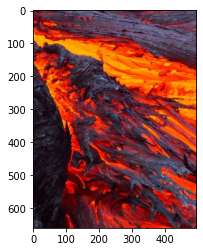

In [25]:
# 합성에 용이하도록 background image 잘라내기
background_img_crop = background_img_orig[0:661, 0:496]

print(background_img_crop.shape)
plt.imshow(cv2.cvtColor(background_img_crop, cv2.COLOR_BGR2RGB))
plt.show()

계획은 위태로운 양이 용암 위에 있음을 표현하기

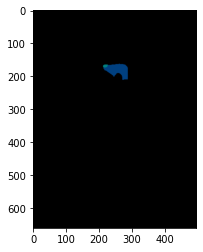

In [26]:
segvalues, output = model.segmentAsPascalvoc(img_path)

# 세그멘테이션 결과가 각각 다른 색상으로 표현됨
plt.imshow(output)
plt.show()

In [27]:
# class의 id와 masks 확인 가능
print(segvalues)

# class id를 통해 어떤 물체인지 확인
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    
# 양을 나타내는 17번째의 색상
print('sheep is', colormap[17])
print('bird', colormap[3])

{'class_ids': array([ 0,  3, 17]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
background
bird
sheep
sheep is [128  64   0]
bird [128 128   0]


(661, 496)


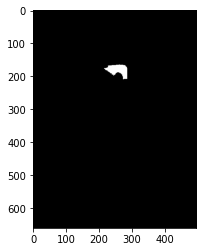

In [28]:
# output의 이미지가 BGR 순서로 배치되어 있으므로 colormap의 RGB 순서처럼 바꿔줘야함
seg_color = (0,64,128)

# output의 픽셀 색상이 seg_color와 같으면 1(true) 다르면 0(false)이 된다.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

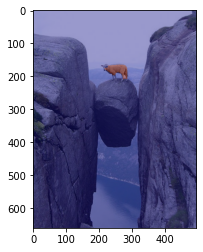

In [29]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾼다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율이다
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

(1333, 2000, 3)


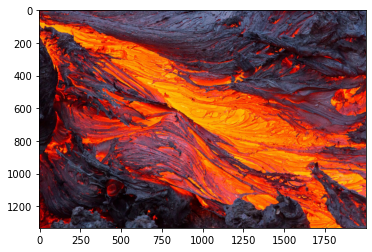

In [30]:
background_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/magma.jpeg'
background_img_orig = cv2.imread(background_img_path) 

print(background_img_orig.shape)
plt.imshow(cv2.cvtColor(background_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

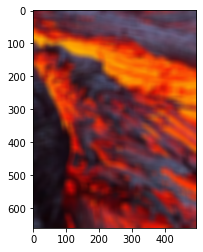

In [31]:
# 배경 blur 적용
img_orig_blur = cv2.blur(background_img_crop, (20,20)) # 숫자를 키우면 블러 효과 증대
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

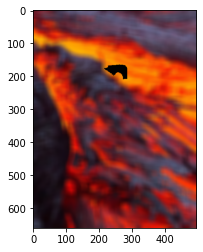

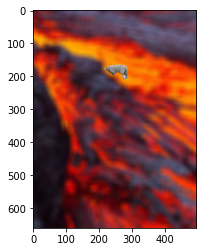

In [32]:
# 세그멘테이션 마스크로 배경 추출하기
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 흐린 배경과 원본 이미지 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# np.where(조건, 참일때, 거짓일떄) 를 사용해서 합성했다.
result = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
plt.imshow(result)
plt.show()

In [33]:
plt.imsave(f'result_images/sheep_on_the_magma.jpeg', result) # 결과 이미지 저장

# 결과물에서 문제점 찾기

- 셀카   
작게 보면 앞에있는 본인과 배경이 제대로 나눠져 있는 모습을 볼 수 있다. 하지만 자세히 보면 끝부분의 디테일이 부족한걸 볼 수 있다. 더 완벽한 결과물을 내려면 경계면 사이를 보완해야할거같다.
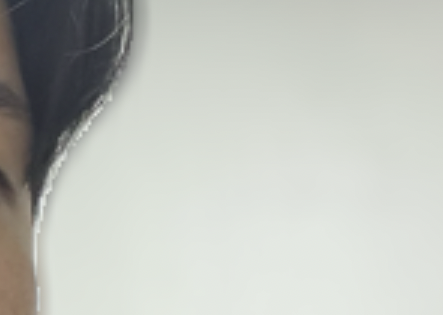



- 고양이   
고양이도 작게 봤을땐 괜찮아 보이지만 끝부분 털의 디테일이 다 죽어있다. 셀카의 결과물보다 더 안좋게 나왔다. 특히 굵은 귀와 코털은 이질감이 많이 든다. 시맨틱 세그멘테이션을 하는 모델이 작은 픽셀은 무시하고 큰 덩어리 형태만 인식하여 나온 문제라고 생각한다.
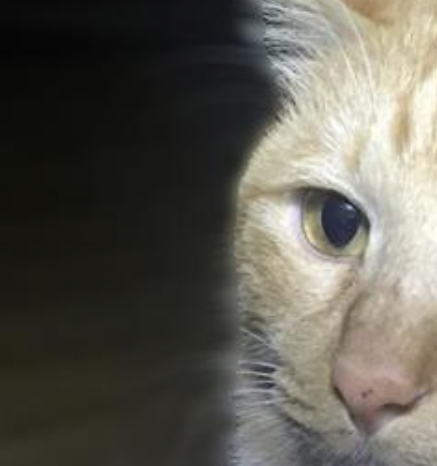

- 배경 합성    
가장 결과물이 안좋게 나왔다. 26, 27번째 코드 블럭을 보면 양이 너무 작아서 얼굴 부분은 bird로 인식하고 있다. 그리고 다리 부분도 제대로 인식하지 못했다.
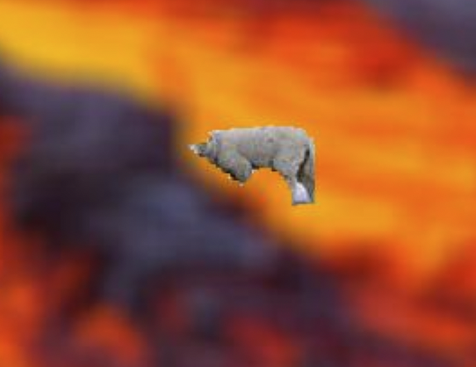

# 해결 방법은 없을까?

문제를 정리하자면 다음과 같다.   
> 1. sementic segmentation이 잡은 Mask 영역과 아닌 부분을 합성할 때 경계면의 디테일이 부족하다.
2. 인식하는 이미지가 작을 경우 라벨링을 제대로 인식하지 못하는 경우가 있다.

# 어떻게 해결해야 할까?

1. sementic segmentation으로 합성할 때 경계면의 디테일이 부족할땐 Bilateral filter로 블러를 적용한다.   
가장 큰 문제는 시멘틱 시그멘테이션이 mask 영역과 아닌 부분을 제대로 인식하지 않는다는 문제가 있다. 그래서 이를 사용하지 않고 경계선을 유지하면서 블러처리하는 양방향 필터(Bilateral filter)를 적용하면 결과물이 더 좋을 것이라 생각한다.   

고양이 사진으로 한번 적용해보자.

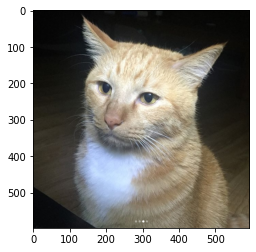

In [34]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'
img_orig = cv2.imread(img_path) 

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

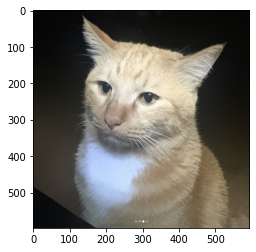

In [35]:
dst = cv2.bilateralFilter(img_orig, d=-1, sigmaColor=30, sigmaSpace=30)

plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
result = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
plt.show()

In [36]:
plt.imsave(f'result_images/bilateralFilter.jpeg', result) # 결과 이미지 저장

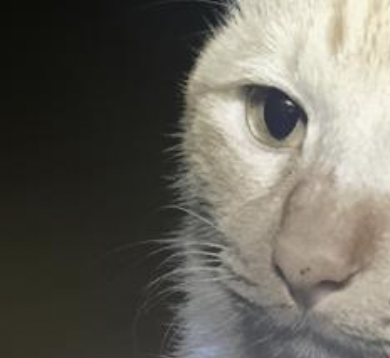

색의 밸런스는 무너졌지만 경계면 사이는 sementic segmentation보다 결과물이 월등하게 좋아졌다.   
`cv2.bilateralFilter()`는 기준 픽셀과 이웃 픽셀과의 거리, 픽셀값의 깊이 차이를 고려해서 블러링을 주는 함수다. 

2. 인식하는 이미지가 작을 경우에는 스케일을 조절해서 해결하기   
양과 용암을 합성하는 이미지에서 라벨링 과정을 통해 양이 제대로 검출되지 않는 이유는 양의 이미지가 너무 작아서 simentic segmentation이 인식을 못했다고 생각했다. 그래서 어떻게 해결하냐면 ex 3번 카메라 스티커 앱 만들기에서 얼굴을 검출하기 위해 upsampling 하는 과정에서 영감받았다.   
이미지를 upsampling으로 크기를 키운다 -> 시맨틱 세그멘테이션으로 마스크 영역을 추출한다 -> 합성하려는 배경을 블러 효과를 준다 -> 추출한 이미지만 가져와서 downsampling으로 기존 사이즈와 동일하게 맞춘다 -> 합성한다   
순서대로 진행한다면 양을 제대로 인식하고 합성할 수 있다고 생각한다.

# 회고

- 프로젝트를 진행하면서 한 가지 궁금한 점이 생겼다. 셀카 인물사진을 보면 픽셀이 뚝뚝 끊기게 인식되어 있어서 자연스럽지 않다. 만약 픽셀의 밀도가 높은 고화질의 사진을 줬을 때 모델은 어떻게 인식할까?   
- 사람이 이미지를 봤을때 뒷 배경과 앞에있는 사물을 구별하기 쉽다. 하지만 2D 이미지로 컴퓨터가 인식할때 이 사이를 구별하기란 쉽지 않았다. 그래서 `cv2.bilateralFilter()`를 이용한 뒷 배경과 사물의 픽셀 차이로 해결했는데 만약 뒷 배경과 앞에있는 사물의 색상이 비슷하다면 어떻게 인식할까? 아마 제대로 인식하지 않을것 같다.   
- 최근의 아이폰을 보면 TOF 센서가 달려있는데 이는 적외선 빛을 쏴서 방출 시간과 반사해서 돌아오는 시간의 시간차를 이용해서 깊이감을 조절하는 센서다. 그리고 아이폰의 후방카메라를 이용한 인물사진은 카메라로 찍은것처럼 자연스럽게 나온다. 아마 이런 센서를 활용해서 가능했다고 생각한다. 앞으로는 이미지에 이런 다양한 센서 값이 기본으로 들어갈 날이 오지 않을까 추측해본다. 그리고 이런 부류를 집중해서 연구하기에 좋아보이고 다양한 센서를 이용해서 얻은 데이터를 꼭 핸들링 해보고 싶다고 생각했다.